In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

from gaussian_process import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
df = pd.read_csv("../Metro_Interstate_Traffic_Volume.csv")
df['date_time'] = pd.to_datetime(df['date_time'])
df['hour'] = df['date_time'].dt.hour
df['day_of_week'] = df['date_time'].dt.dayofweek
df['month'] = df['date_time'].dt.month
df['year'] = df['date_time'].dt.year
df['is_holiday'] = (~ df['holiday'].isnull()).astype(int)
df['time_step'] = (df['date_time'] - pd.Timestamp("2012-10-02 09:00:00")) // pd.Timedelta(hours=1) # hours since 2012-10-20 9am

# Training data
df_train = df[df['date_time'].dt.year.isin([2016, 2017])] # 2016, 2016 as training data
df_test = df[df['date_time'].dt.year.isin([2018])] # 2018 for validation

# only include time data
X_train = df_train[['time_step']]
X_test = df_test[['time_step']]

y_train = df_train['traffic_volume']
y_test = df_test['traffic_volume']

In [12]:
print(len(X_train))
print(len(X_test))

19911
7949


In [13]:
def adj_gp_posterior(X_train, y_train, X_test, kernel, noise=1e-8, **kwargs):
    """Compute posterior mean and covariance of GP. Returns mean and covariance for train and test as well as alpha and v"""
    n = len(X_train)
    n_tst = len(X_test)

    print("Computing Gram Matrix")
    K = kernel(X_train, X_train, **kwargs)
    K_noisy = K + noise * np.eye(n) # kernel fcn between train data (plus noise)
    b = kernel(X_train, X_test, **kwargs) # kernel fcn between train and test data
    c = kernel(X_test, X_test, **kwargs)# kernel fcn between test data

    print('Computing Cholesky Decomposition')
    L = np.linalg.cholesky(K_noisy)

    print('Computing alpha')
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_train))

    print('Computing Mean and Covariance')
    mu_tst = b.T.dot(alpha) # mean for test points
    mu_tr = K.dot(alpha)
    v = np.linalg.solve(L, b)
    cov_tst = c - v.T @ v


    return mu_tst, cov_tst, mu_tr, alpha, v

In [ ]:
l = 0.1
p = 24*7
s = 1.0

print(f'Length Scale = {l}, Period = {p}, Variance = {s}')

# fit GP model
mean_test, cov_test, mean_train, _, _ = adj_gp_posterior(X_train, y_train, X_test, periodic_kernel, length_scale = l, period = p, variance = s)

# get interval for test
stdv = np.sqrt(np.diag(cov_test))
upper = mean_test + 2 * stdv
lower = mean_test - 2 * stdv

Length Scale = 0.1, Period = 168, Variance = 1.0
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance


In [33]:
train_rmse = rmse(y_train, mean_train)
test_rmse = rmse(y_test, mean_test)

train_mae = mae(y_train, mean_train)
test_mae = mae(y_test, mean_test)

print(f"Train RMSE : {train_rmse}")
print(f"Test RMSE : {test_rmse}")

print(f"Train MAE : {train_mae}")
print(f"Test MAE : {test_mae}")

ValueError: operands could not be broadcast together with shapes (10605,) (19911,) 

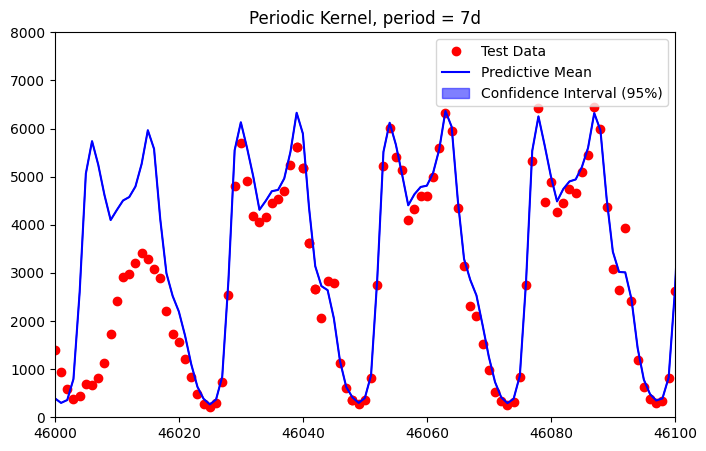

In [16]:
# Plot
plt.figure(figsize=(8, 5))
plt.plot(X_test['time_step'], y_test, 'ro', label='Test Data')

plt.plot(X_test['time_step'], mean_test, 'b-', label='Predictive Mean')
plt.fill_between(X_test['time_step'], lower, upper, color='blue', alpha=0.5, label='Confidence Interval (95%)')
plt.title(f"Periodic Kernel, period = 7d")
plt.xlim(46000, 46100)
plt.ylim(0, 8000)
plt.legend()
plt.show()

## Test Experiments

In [14]:
# periodic kernel experiments (1 week)
lst_l = [0.01, 0.1, 1]
p = 24*7
s = 1

results = []


for l in lst_l:
    print(f'Length Scale = {l}, Period = {p}, Variance = {s}')
    mean_test, cov_test, mean_train, alpha, v = adj_gp_posterior(X_train, y_train, X_test, periodic_kernel, length_scale = l, period = p, variance = s)

    # get interval for test
    stdv = np.sqrt(np.diag(cov_test))
    upper = mean_test + 2 * stdv
    lower = mean_test - 2 * stdv

    train_rmse = rmse(y_train, mean_train)
    test_rmse = rmse(y_test, mean_test)

    train_mae = mae(y_train, mean_train)
    test_mae = mae(y_test, mean_test)

    print(f"Train RMSE : {train_rmse}")
    print(f"Test RMSE : {test_rmse}")
    
    #print(f"Train MAE : {train_mae}")
    #print(f"Test MAE : {test_mae}")

    np.save(f'../results/alpha_periodic_1w_l{l}_s{s}', alpha) # save alpha matrix
    np.save(f'../results/mean_test_1w_l{l}_s{s}', mean_test)
    np.save(f'../results/cov_test_1w_l{l}_s{s}', cov_test)
    np.save(f'../results/mean_train_1w_l{l}_s{s}', mean_train)

    results.append({
        'length_scale': l,
        'period': p,
        'variance': s,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae
    })
    print()

results = pd.DataFrame(results)
print(results)

Length Scale = 0.01, Period = 168, Variance = 1
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE : 504.019878212502
Test RMSE : 524.0630710810844

Length Scale = 0.1, Period = 168, Variance = 1
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE : 504.2502112838889
Test RMSE : 524.0647542148128

Length Scale = 1, Period = 168, Variance = 1
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE : 1010.9311065378025
Test RMSE : 1017.5635771770341

   length_scale  period  variance   train_rmse    test_rmse  train_mae  \
0          0.01     168         1   504.019878   524.063071  17.135188   
1          0.10     168         1   504.250211   524.064754  17.147068   
2          1.00     168         1  1010.931107  1017.563577  27.551699   

    test_mae  
0  17.196407  
1  17.207549  
2  27.748805  


In [15]:
# periodic kernel experiments (30 days)
lst_l = [0.01, 0.1, 1]
p = 24*30
s = 1

results = []

for l in lst_l:
    print(f'Length Scale = {l}, Period = {p}, Variance = {s}')
    mean_test, cov_test, mean_train, alpha, v = adj_gp_posterior(X_train, y_train, X_test, periodic_kernel, length_scale = l, period = p, variance = s)

    # get interval for test
    stdv = np.sqrt(np.diag(cov_test))
    upper = mean_test + 2 * stdv
    lower = mean_test - 2 * stdv

    train_rmse = rmse(y_train, mean_train)
    test_rmse = rmse(y_test, mean_test)

    train_mae = mae(y_train, mean_train)
    test_mae = mae(y_test, mean_test)

    print(f"Train RMSE : {train_rmse}")
    print(f"Test RMSE : {test_rmse}")
    
    #print(f"Train MAE : {train_mae}")
    #print(f"Test MAE : {test_mae}")

    np.save(f'../results/alpha_periodic_30d_l{l}_s{s}', alpha) # save alpha matrix
    np.save(f'../results/mean_test_30d_l{l}_s{s}', mean_test)
    np.save(f'../results/cov_test_30d_l{l}_s{s}', cov_test)
    np.save(f'../results/mean_train_30d_l{l}_s{s}', mean_train)
    
    results.append({
        'length_scale': l,
        'period': p,
        'variance': s,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae
    })
    print()

results = pd.DataFrame(results)
display(results)

Length Scale = 0.01, Period = 720, Variance = 1
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE : 908.343070329353
Test RMSE : 964.9699512434387

Length Scale = 0.1, Period = 720, Variance = 1
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE : 1045.127533052838
Test RMSE : 1079.4898307087992

Length Scale = 1, Period = 720, Variance = 1
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE : 1968.7541202106447
Test RMSE : 1973.1704943588281



,length_scale,period,variance,train_rmse,test_rmse,train_mae,test_mae
0,0.01,720,1,908.343070,964.969951,24.729560,25.533600
1,0.10,720,1,1045.127533,1079.489831,27.696265,28.144226
2,1.00,720,1,1968.754120,1973.170494,41.599969,41.565729


In [16]:
# periodic kernel experiments (365 days)
lst_l = [0.01, 0.1, 1]
p = 24*365
s = 1

results = []

for l in lst_l:
    print(f'Length Scale = {l}, Period = {p}, Variance = {s}')
    mean_test, cov_test, mean_train, alpha, v = adj_gp_posterior(X_train, y_train, X_test, periodic_kernel, length_scale = l, period = p, variance = s)

    # get interval for test
    stdv = np.sqrt(np.diag(cov_test))
    upper = mean_test + 2 * stdv
    lower = mean_test - 2 * stdv

    train_rmse = rmse(y_train, mean_train)
    test_rmse = rmse(y_test, mean_test)

    train_mae = mae(y_train, mean_train)
    test_mae = mae(y_test, mean_test)

    print(f"Train RMSE : {train_rmse}")
    print(f"Test RMSE : {test_rmse}")
    
    #print(f"Train MAE : {train_mae}")
    #print(f"Test MAE : {test_mae}")

    np.save(f'../results/alpha_periodic_365d_l{l}_s{s}', alpha) # save alpha matrix
    np.save(f'../results/mean_test_365d_l{l}_s{s}', mean_test)
    np.save(f'../results/cov_test_365d_l{l}_s{s}', cov_test)
    np.save(f'../results/mean_train_365d_l{l}_s{s}', mean_train)
    
    results.append({
        'length_scale': l,
        'period': p,
        'variance': s,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae
    })

    print()

results = pd.DataFrame(results)
display(results)

Length Scale = 0.01, Period = 8760, Variance = 1
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE : 971.3840574612678
Test RMSE : 1308.6678906821942

Length Scale = 0.1, Period = 8760, Variance = 1
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE : 1926.850566887171
Test RMSE : 1985.6618697804624

Length Scale = 1, Period = 8760, Variance = 1
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE : 1962.645354920789
Test RMSE : 1977.3158143036483



,length_scale,period,variance,train_rmse,test_rmse,train_mae,test_mae
0,0.01,8760,1,971.384057,1308.667891,727.010672,998.101065
1,0.10,8760,1,1926.850567,1985.661870,1693.576771,1727.298521
2,1.00,8760,1,1962.645355,1977.315814,1725.094099,1728.478889


In [ ]:
# rbf kernel
lst_l = [0.01, 0.1, 1]
s = 1

results = []

for l in lst_l:
    print(f'Length Scale = {l}, Period = {p}, Variance = {s}')
    mean_test, cov_test, mean_train, alpha, v = adj_gp_posterior(X_train, y_train, X_test, rbf_kernel, length_scale = l, variance = s)

    # get interval for test
    stdv = np.sqrt(np.diag(cov_test))
    upper = mean_test + 2 * stdv
    lower = mean_test - 2 * stdv

    train_rmse = rmse(y_train, mean_train)
    test_rmse = rmse(y_test, mean_test)

    train_mae = mae(y_train, mean_train)
    test_mae = mae(y_test, mean_test)

    print(f"Train RMSE : {train_rmse}")
    print(f"Test RMSE : {test_rmse}")
    
    #print(f"Train MAE : {train_mae}")
    #print(f"Test MAE : {test_mae}")

    np.save(f'../results/alpha_rbf_l{l}_s{s}', alpha) # save alpha matrix
    np.save(f'../results/mean_test_rbf_l{l}_s{s}', mean_test)
    np.save(f'../results/cov_test_rbf_l{l}_s{s}', cov_test)
    np.save(f'../results/mean_train_rbf_l{l}_s{s}', mean_train)
    
    results.append({
        'length_scale': l,
        'period': p,
        'variance': s,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae
    })

    print()

results = pd.DataFrame(results)
print(results)

Length Scale = 0.01, Period = 8760, Variance = 1
Computing Gram Matrix


In [ ]:
# sum of periodic

In [ ]:
# sum of periodic, rbf scaling